## Importing libraries

In [4]:
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import probplot, moment

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

import pandas_datareader.data as web

import matplotlib.pyplot as plt
import seaborn as sns

from utils import general_utils

import warnings
warnings.filterwarnings('ignore')

### Auxillary Function

In [3]:
general_utils.plot_correlogram??

Signature:
general_utils.plot_correlogram(
    x: pandas.core.series.Series,
    lags: int = None,
    title: str = None,
) -> None
Docstring: <no docstring>
Source:   
def plot_correlogram(
    x: pd.Series, lags: int = None, title: str = None
) -> None:
    lags = min(10, int(len(x) / 5)) if lags is None else lags
    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        fig.tight_layout(pad=5)

        x.plot(ax=axes[0][0], title="Residuals")
        x.rolling(21).mean().plot(ax=axes[0][0], c="k", lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f"Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}"
        axes[0][0].text(
            x=0.02, y=0.85, s=stats, transform=axes[0][0].transAxes
        )

        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f"Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurto

## Data

In [6]:
nasdaq = web.DataReader('NASDAQCOM', 'fred', '2000', '2020').squeeze()
nasdaq_returns = np.log(nasdaq).diff().dropna().mul(100) # rescale to faciliate optimization

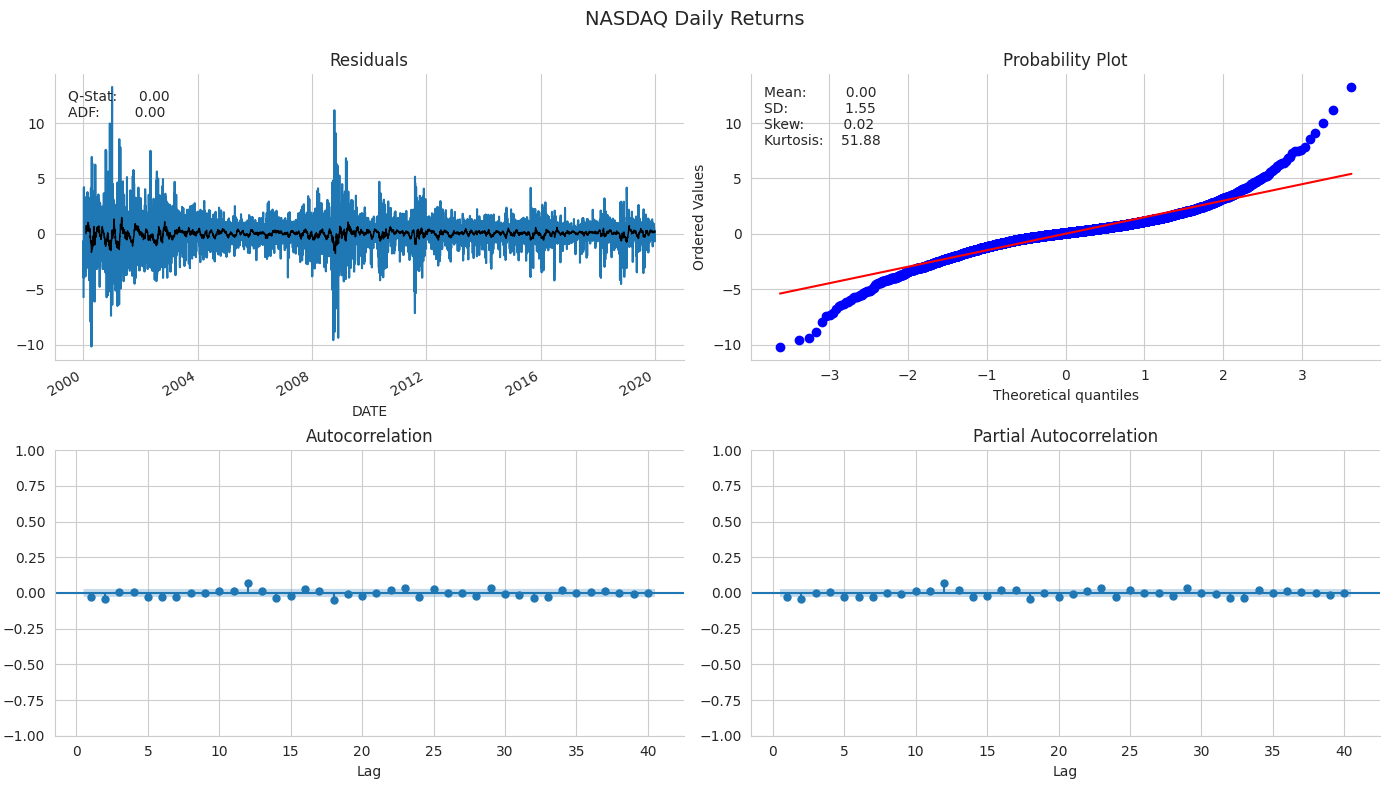

In [10]:
general_utils.plot_correlogram(nasdaq_returns, lags=40, title='NASDAQ Daily Returns')

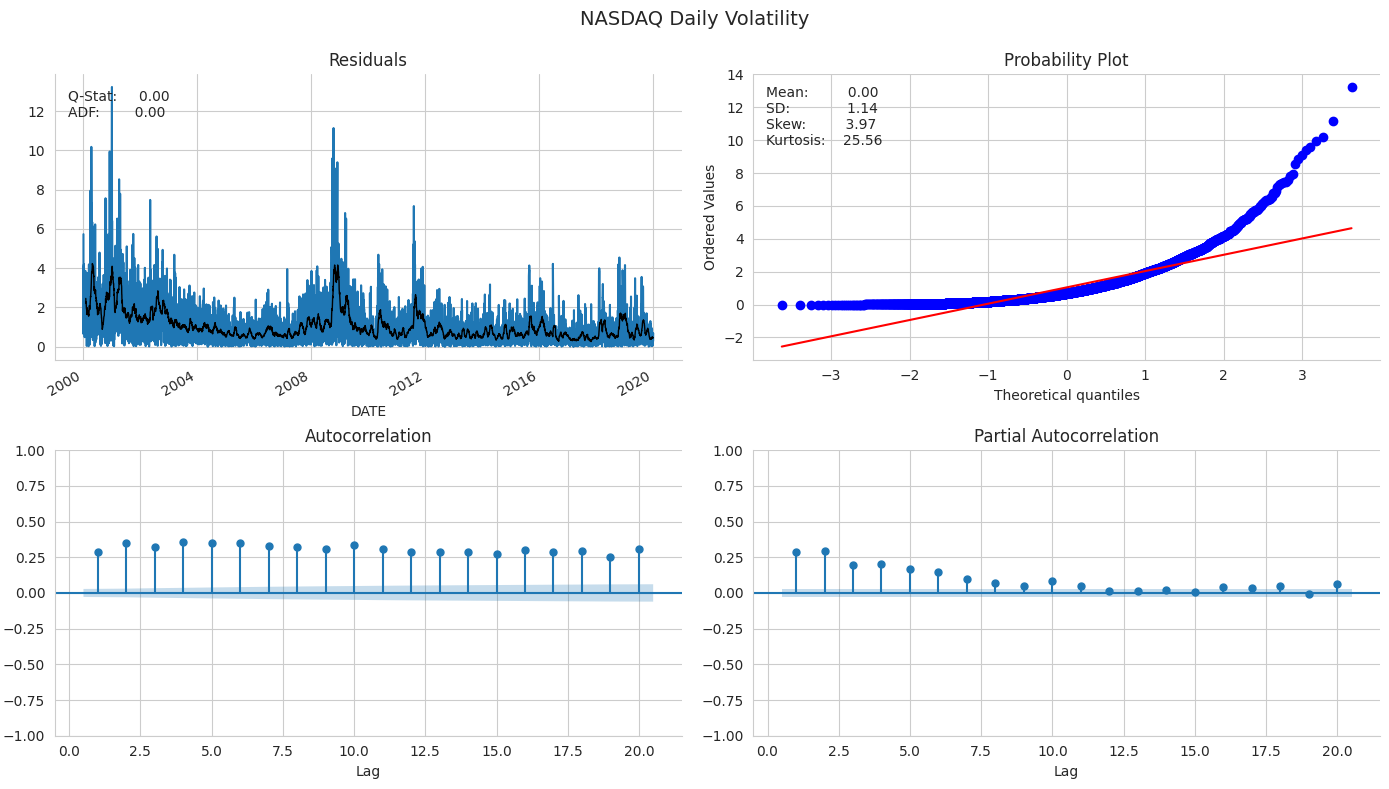

In [11]:
general_utils.plot_correlogram(nasdaq_returns.sub(nasdaq_returns.mean()).pow(2).pow(0.5), lags=20, title='NASDAQ Daily Volatility')

### GARCH
- https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/09_time_series_models/03_arch_garch_models.ipynb

In [5]:
GARCH??

Init signature: GARCH(p: 'int' = 1, o: 'int' = 0, q: 'int' = 1, power: 'float' = 2.0) -> 'None'
Source:        
class GARCH(VolatilityProcess, metaclass=AbstractDocStringInheritor):
    r"""
    GARCH and related model estimation

    The following models can be specified using GARCH:
        * ARCH(p)
        * GARCH(p,q)
        * GJR-GARCH(p,o,q)
        * AVARCH(p)
        * AVGARCH(p,q)
        * TARCH(p,o,q)
        * Models with arbitrary, pre-specified powers

    Parameters
    ----------
    p : int
        Order of the symmetric innovation
    o : int
        Order of the asymmetric innovation
    q : int
        Order of the lagged (transformed) conditional variance
    power : float, optional
        Power to use with the innovations, abs(e) ** power.  Default is 2.0, which produces ARCH
        and related models. Using 1.0 produces AVARCH and related models.  Other powers can be
        specified, although these should be strictly positive, and usually larger than 0.25.
